In [14]:
import os
from itertools import chain

from IPython.core.debugger import prompt
from dotenv import load_dotenv
from langchain_core.output_parsers import StrOutputParser
from langchain_core.prompts import ChatPromptTemplate
from langchain_core.runnables import Runnable, RunnableLambda
from langchain.schema.output_parser import StrOutputParser

load_dotenv(r"H:\My_LangGraph_toturial\.env")
os.environ["OPENAI_API_KEY"] = os.getenv("OPENAI_API_KEY")


### Runnable code

In [11]:
from langchain_openai import ChatOpenAI
model = ChatOpenAI(model_name="gpt-3.5-turbo")
prompt_template = ChatPromptTemplate.from_messages(
    messages=[
        ("system", "you love facts and you tell facts about {animal}"),
        ("user", "tell {count} about {animal}")
    ]
)

def format_prompt(context):
    return prompt_template.format(**context)
def invoke_model(context):
    return model.invoke(context)
def parse_output(context):
    return context.content

format_prompt = RunnableLambda(format_prompt)
# output = format_prompt.invoke({"animal": "dog", "count": 3})
# print(output)
invoke_model = RunnableLambda(invoke_model)

# chain = format_prompt | invoke_model
# output = chain.invoke({"animal": "dog", "count": 3})
parse_output = RunnableLambda(parse_output)
# print(parse_output)

# Create the RunnableSequence (equivalent to the LCEL chain)
# chain = RunnableSequence(first=format_prompt, middle=[invoke_model], last=parse_output)

chain = format_prompt | invoke_model | parse_output
output = chain.invoke({"animal": "dog", "count": 3})
print(output)

1. Dogs have an amazing sense of smell and can detect scents up to 100,000 times better than humans.
2. The Basenji is the only dog breed that does not bark, instead they make a unique yodel-like sound called a "barroo."
3. The world's oldest known breed of domesticated dog is the Saluki, which dates back over 7,000 years.


### Sequential Chain


In [21]:
# Define prompt templates
animal_facts_template = ChatPromptTemplate.from_messages(
    [
        ("system", "You like telling facts and you tell facts about {animal}."),
        ("human", "Tell me {count} facts."),
    ]
)

# Define a prompt template for translation to French
translation_template = ChatPromptTemplate.from_messages(
    [
        ("system", "You are a translator and convert the provided text into {language}."),
        ("human", "Translate the following text to {language}: {text}"),
    ]
)

# Define additional processing steps using RunnableLambda
prepare_for_translation = RunnableLambda(lambda output: {"text": output, "language": "french"})

chain = animal_facts_template | model | StrOutputParser()  | prepare_for_translation | translation_template | model | StrOutputParser()
result = chain.invoke({"animal": "dog", "count": 1})
result

"Le sens de l'odorat d'un chien est jusqu'à 100 000 fois plus sensible que celui d'un humain, ce qui leur permet de détecter des odeurs à de grandes distances et même sous terre."

### Parallel Chain
#### Imagine you have an article or blog post, and you want to:
* Summarize it in plain English.
* Extract Key Entities (like people or places mentioned).
* Generate an SEO-friendly Title.
* Each of these tasks can run in parallel. Then, you’ll combine the results at the end.

In [27]:
from langchain.schema.runnable import RunnableParallel

def format_summary_prompt(content):
    summary_template = ChatPromptTemplate.from_messages(
    [
        ("system", "You are an AI assistant that summarizes text."),
        ("human", "Please summarize this article:\n{article_content}")
    ]
    )
    return summary_template.format_prompt(article_content=content)

def format_entity_prompt(content):
    entity_template = ChatPromptTemplate.from_messages(
    [
        ("system", "You are an AI assistant that extracts key entities from text."),
        ("human", "Identify the main people, organizations, and places in this text:\n{article_content}")
    ]
    )
    return entity_template.format_prompt(article_content=content)

def format_title_prompt(content):
    title_template = ChatPromptTemplate.from_messages(
    [
        ("system", "You are an AI assistant that creates SEO-friendly titles."),
        ("human", "Create an SEO-friendly title for this article:\n{article_content}")
    ]
    )
    return title_template.format_prompt(article_content=content)

summary_branch = (
    RunnableLambda(lambda x: format_summary_prompt(x))  # Format prompt
    | model                                            # Call the LLM
    | StrOutputParser()                                # Parse output to string
)

entity_branch = (
    RunnableLambda(lambda x: format_entity_prompt(x))
    | model
    | StrOutputParser()
)

title_branch = (
    RunnableLambda(lambda x: format_title_prompt(x))
    | model
    | StrOutputParser()
)

parallel_chain = RunnableParallel(
    branches={
        "summary": summary_branch,
        "entities": entity_branch,
        "title": title_branch
    }
)

def combine_results(results):
    summary = results['branches']["summary"]  # branch output has the same key as the branch name
    entities = results['branches']["entities"]
    title = results['branches']["title"]
    return f"---\nTitle: {title}\n\n\n\n Summary:\n{summary}\n\n\n\n Key Entities:\n{entities}\n---"
combine_results = RunnableLambda(combine_results)

prompt_1 = ChatPromptTemplate.from_messages(
    [
        ("system", "You are an AI assistant."),
        ("human", "Summarize, extract key entities, and generate an SEO-friendly title for this article:\n{article_content}"),
    ]
)

final_chain = (
        prompt_1 | parallel_chain | combine_results
)

article_text = """
OpenAI, based in San Francisco, has partnered with various organizations to advance AI research.
Many experts, including Sam Altman, have contributed to its success.
"""

result = final_chain.invoke({"article_content" : article_text})
result


'---\nTitle: "OpenAI\'s Partnership and Success in Advancing AI Research: Insights from Key Experts"\n\n\n\n Summary:\nThe article is about OpenAI, a company based in San Francisco, that has partnered with different organizations to advance AI research. The success of OpenAI has been attributed to the contributions of many experts, including Sam Altman. The key entities are OpenAI, San Francisco, AI research, and Sam Altman. An SEO-friendly title for this article could be: "OpenAI’s Success in AI Research: A Collaborative Partnership with Organizations Led by Sam Altman."\n\n\n\n Key Entities:\nBased on the provided text, the key entities are:\n\nPeople:\n- Sam Altman\n\nOrganizations:\n- OpenAI\n\nPlaces:\n- San Francisco\n---'

In [ ]:
summary_template = ChatPromptTemplate.from_messages(
    [
        ("system", "You are a movie critic."),
        ("human", "Provide a brief summary of the movie {movie_name}."),
    ]
)

# Define plot analysis step
def analyze_plot(plot):
    plot_template = ChatPromptTemplate.from_messages(
        [
            ("system", "You are a movie critic."),
            ("human", "Analyze the plot: {plot}. What are its strengths and weaknesses?"),
        ]
    )
    return plot_template.format_prompt(plot=plot)

# Define character analysis step
def analyze_characters(characters):
    character_template = ChatPromptTemplate.from_messages(
        [
            ("system", "You are a movie critic."),
            ("human", "Analyze the characters: {characters}. What are their strengths and weaknesses?"),
        ]
    )
    return character_template.format_prompt(characters=characters)

# Combine analyses into a final verdict
def combine_verdicts(plot_analysis, character_analysis):
    return f"Plot Analysis:\n{plot_analysis}\n\nCharacter Analysis:\n{character_analysis}"

# Simplify branches with LCEL
plot_branch_chain = (
    RunnableLambda(lambda x: analyze_plot(x)) | model | StrOutputParser()
)

character_branch_chain = (
    RunnableLambda(lambda x: analyze_characters(x)) | model | StrOutputParser()
)

# Create the combined chain using LangChain Expression Language (LCEL)
chain = (
    summary_template
    | model
    | StrOutputParser()
    | RunnableParallel(branches={"plot": plot_branch_chain, "characters": character_branch_chain})
    | RunnableLambda(lambda x: combine_verdicts(x["branches"]["plot"], x["branches"]["characters"]))
)

# Run the chain
result = chain.invoke({"movie_name": "Inception"})

In [32]:
from typing import TypedDict, List, Annotated
from langgraph.graph import StateGraph, END , START
from langchain.prompts import ChatPromptTemplate

class GraphState(TypedDict):
    movie_name: str
    summary : str
    plot_analysis: str
    character_analysis: str
    final_verdict: str


def analyze_characters(characters):

    return character_template.format_prompt(characters=characters)
# Define Node Functions
def summary_node(state: GraphState) -> GraphState:
    # Define Templates (same as original)
    summary_template = ChatPromptTemplate.from_messages(
        [
            ("system", "You are a movie critic."),
            ("human", "Provide a brief summary of the movie {movie_name}."),
        ]
    )
    chain = summary_template | model | StrOutputParser()
    summary = chain.invoke({"movie_name": state["movie_name"]})
    return {"summary": summary}

def plot_analysis_node(state: GraphState) -> GraphState:
    # Generate the plot analysis
    plot_template = ChatPromptTemplate.from_messages(
        [
            ("system", "You are a movie critic."),
            ("human", "Analyze the plot: {plot}. What are its strengths and weaknesses?"),
        ]
    )
    chain = plot_template | model | StrOutputParser()
    chain_output = chain.invoke({"plot": state["summary"]})
    return {"plot_analysis": chain_output}

def character_analysis_node(state: GraphState) -> GraphState:
    # Analyze the characters from the summary
    character_template = ChatPromptTemplate.from_messages(
        [
            ("system", "You are a movie critic."),
            ("human", "Analyze the characters: {characters}. What are their strengths and weaknesses?"),
        ]
    )

    chain =  character_template | model | StrOutputParser()
    character_analysis = chain.invoke({"characters":state["summary"]})
    return {"character_analysis": character_analysis}

def combine_verdicts_node(state: GraphState) -> GraphState:
    # Combine plot and character analyses
    final_verdict = f"Plot Analysis:\n{state['plot_analysis']}\n\nCharacter Analysis:\n{state['character_analysis']}"
    return {"final_verdict": final_verdict}

workflow = StateGraph(state_schema=GraphState)

# Add nodes
workflow.add_node("summary_node", summary_node)
workflow.add_node("plot_analysis_node", plot_analysis_node)
workflow.add_node("character_analysis_node", character_analysis_node)
workflow.add_node("combine_verdicts", combine_verdicts_node)

workflow.set_entry_point("summary_node")
workflow.add_edge("summary_node", "plot_analysis_node")  # Summary -> Plot Analysis
workflow.add_edge("summary_node", "character_analysis_node")  # Summary -> Character Analysis
workflow.add_edge("plot_analysis_node", "combine_verdicts")  # Plot -> Combine
workflow.add_edge("character_analysis_node", "combine_verdicts")  # Character -> Combine
workflow.add_edge("combine_verdicts", END)  # Combine -> End
graph = workflow.compile()
# Run the graph
initial_state = {"movie_name": "Inception"}
result = graph.invoke(initial_state)
print(result["final_verdict"])



Plot Analysis:
"Inception" stands out as a complex and thought-provoking film that offers a unique and intricate plot. The concept of entering dreams within dreams is fascinating and provides a platform for exploring deep philosophical themes such as the nature of reality, the power of memories, and the subconscious mind. Director Christopher Nolan skillfully navigates through multiple layers of dreams, creating a visually stunning and immersive experience for the audience.

One of the film's strengths lies in its stellar ensemble cast, led by Leonardo DiCaprio as Dom Cobb. The performances are strong and help to ground the fantastical elements of the plot in emotional depth. The film also boasts impressive visual effects and action sequences that keep viewers engaged throughout.

However, one weakness of "Inception" is the complexity of its narrative. The intricate layers of dreams and the rules governing them can be challenging to follow for some viewers, potentially leading to confu

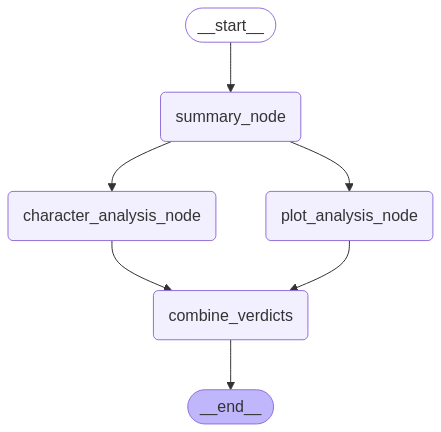

In [33]:
from IPython.core.display import Image

# View
display(Image(graph.get_graph().draw_mermaid_png()))

In [42]:
!pip install -Uq pydantic[email]
from pydantic_core.core_schema import ValidationInfo
from typing import Optional
from pydantic import BaseModel, field_validator
from pydantic import BaseModel, Field, EmailStr

class StudentEntity(BaseModel):
    """
    A general entity class for a student with field validation.
    All fields have default values set to None.
    """
    id: Optional[int] = Field(default=None, description="Unique identifier for the student")
    name: Optional[str] = Field(default=None, description="Full name of the student")
    email: Optional[EmailStr] = Field(default=None, description="Email address of the student")
    age: Optional[int] = Field(default=None, ge=0, le=120, description="Age of the student (must be between 0 and 120)")
    grade: Optional[str] = Field(default=None, description="Grade or academic level of the student")
    enrolled: Optional[bool] = Field(default=None, description="Enrollment status of the student")

    @field_validator('name')
    @classmethod
    def name_must_contain_space(cls, v: str) -> str:
        if ' ' not in v:
            raise ValueError('must contain a space')
        return v.title()

    @field_validator('id', 'name')
    @classmethod
    def check_alphanumeric(cls, v: str, info: ValidationInfo) -> str:
        if isinstance(v, str):
            is_alphanumeric = v.replace(' ', '').isalnum()
            assert is_alphanumeric, f'{info.field_name} must be alphanumeric'
        return v

class GraphState(TypedDict):
    student: StudentEntity
    entities: str
    summary : str
    article_content : str
    title : str
    final_result : str



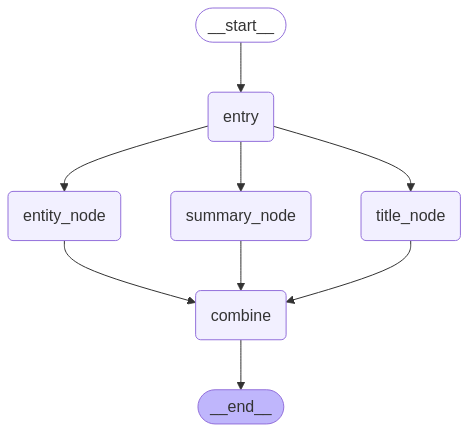

In [44]:
# Define Prompt Formatting Functions (same as original)
def format_summary_prompt(content):
    summary_template = ChatPromptTemplate.from_messages(
        [
            ("system", "You are an AI assistant that summarizes text."),
            ("human", "Please summarize this article:\n{article_content}")
        ]
    )
    return summary_template.format_prompt(article_content=content)

def format_entity_prompt(content):
    entity_template = ChatPromptTemplate.from_messages(
        [
            ("system", "You are an AI assistant that extracts key entities from text."),
            ("human", "Identify the main people, organizations, and places in this text:\n{article_content}")
        ]
    )
    return entity_template.format_prompt(article_content=content)

def format_title_prompt(content):
    title_template = ChatPromptTemplate.from_messages(
        [
            ("system", "You are an AI assistant that creates SEO-friendly titles."),
            ("human", "Create an SEO-friendly title for this article:\n{article_content}")
        ]
    )
    return title_template.format_prompt(article_content=content)

# Define Node Functions
def entry_node(state: GraphState) -> GraphState:
    # Simply pass the article content to the next nodes
    return {"article_content": state["article_content"]}
def summary_node(state: GraphState) -> GraphState:
    chain = RunnableLambda(lambda x: format_summary_prompt(x)) | model | StrOutputParser()
    summary = chain.invoke(state["article_content"])
    return {"summary": summary}

def entity_node(state: GraphState) -> GraphState:
    chain = RunnableLambda(lambda x: format_entity_prompt(x)) | model | StrOutputParser()
    entities = chain.invoke(state["article_content"])
    return {"entities": entities}

def title_node(state: GraphState) -> GraphState:
    chain = RunnableLambda(lambda x: format_title_prompt(x)) | model | StrOutputParser()
    title = chain.invoke(state["article_content"])
    return {"title": title}

def combine_node(state: GraphState) -> GraphState:
    final_result = (
        f"---\n"
        f"Title: {state['title']}\n\n\n\n"
        f"Summary:\n{state['summary']}\n\n\n\n"
        f"Key Entities:\n{state['entities']}\n"
        f"---"
    )
    return {"final_result": final_result}
# Build the Graph
workflow = StateGraph(GraphState)

# Add nodes
workflow.add_node("entry", entry_node)
workflow.add_node("summary_node", summary_node)
workflow.add_node("entity_node", entity_node)
workflow.add_node("title_node", title_node)
workflow.add_node("combine", combine_node)

# Define edges
workflow.add_edge(START,"entry")  # Start with entry node
workflow.add_edge("entry", "summary_node")  # Entry -> Summary
workflow.add_edge("entry", "entity_node")  # Entry -> Entities
workflow.add_edge("entry", "title_node")  # Entry -> Title
workflow.add_edge("summary_node", "combine")  # Summary -> Combine
workflow.add_edge("entity_node", "combine")  # Entities -> Combine
workflow.add_edge("title_node", "combine")  # Title -> Combine
workflow.add_edge("combine", END)  # Combine -> End

# Compile the graph
graph = workflow.compile()
from IPython.core.display import Image

# View
display(Image(graph.get_graph().draw_mermaid_png()))

In [45]:
# Run the graph
article_text = """
OpenAI, based in San Francisco, has partnered with various organizations to advance AI research.
Many experts, including Sam Altman, have contributed to its success.
"""
initial_state = {"article_content": article_text}
result = graph.invoke(initial_state)
result

{'entities': 'People:\n1. Sam Altman\n\nOrganizations:\n1. OpenAI\n\nPlaces:\n1. San Francisco',
 'summary': "The article discusses OpenAI's partnerships with organizations to advance AI research, with contributions from experts like Sam Altman.",
 'article_content': '\nOpenAI, based in San Francisco, has partnered with various organizations to advance AI research.\nMany experts, including Sam Altman, have contributed to its success.\n',
 'title': '"OpenAI\'s Strategic Partnerships in San Francisco Driving AI Research Advancement with Support from Key Industry Experts like Sam Altman"',
 'final_result': '---\nTitle: "OpenAI\'s Strategic Partnerships in San Francisco Driving AI Research Advancement with Support from Key Industry Experts like Sam Altman"\n\n\n\nSummary:\nThe article discusses OpenAI\'s partnerships with organizations to advance AI research, with contributions from experts like Sam Altman.\n\n\n\nKey Entities:\nPeople:\n1. Sam Altman\n\nOrganizations:\n1. OpenAI\n\nPlaces

### Conditional Chain

In [29]:
from langchain.schema.runnable import RunnableBranch
# Define prompt templates for different feedback types
positive_feedback_template = ChatPromptTemplate.from_messages(
    [
        ("system", "You are a helpful assistant."),
        ("human",
         "Generate a thank you note for this positive feedback: {feedback}."),
    ]
)

negative_feedback_template = ChatPromptTemplate.from_messages(
    [
        ("system", "You are a helpful assistant."),
        ("human",
         "Generate a response addressing this negative feedback: {feedback}."),
    ]
)

neutral_feedback_template = ChatPromptTemplate.from_messages(
    [
        ("system", "You are a helpful assistant."),
        (
            "human",
            "Generate a request for more details for this neutral feedback: {feedback}.",
        ),
    ]
)

escalate_feedback_template = ChatPromptTemplate.from_messages(
    [
        ("system", "You are a helpful assistant."),
        (
            "human",
            "Generate a message to escalate this feedback to a human agent: {feedback}.",
        ),
    ]
)

# Define the feedback classification template
classification_template = ChatPromptTemplate.from_messages(
    [
        ("system", "You are a helpful assistant."),
        ("human",
         "Classify the sentiment of this feedback as positive, negative, neutral, or escalate: {feedback}."),
    ]
)

# Define the runnable branches for handling feedback
branches = RunnableBranch(
    (
        lambda x: "positive" in x,
        positive_feedback_template | model | StrOutputParser()  # Positive feedback chain
    ),
    (
        lambda x: "negative" in x,
        negative_feedback_template | model | StrOutputParser()  # Negative feedback chain
    ),
    (
        lambda x: "neutral" in x,
        neutral_feedback_template | model | StrOutputParser()  # Neutral feedback chain
    ),
    escalate_feedback_template | model | StrOutputParser()
)

# Create the classification chain
classification_chain = classification_template | model | StrOutputParser()

# Combine classification and response generation into one chain
chain = classification_chain | branches

# Run the chain with an example review
# Good review - "The product is excellent. I really enjoyed using it and found it very helpful."
# Bad review - "The product is terrible. It broke after just one use and the quality is very poor."
# Neutral review - "The product is okay. It works as expected but nothing exceptional."
# Default - "I'm not sure about the product yet. Can you tell me more about its features and benefits?"

review = "The product is terrible. It broke after just one use and the quality is very poor."
result = chain.invoke({"feedback": review})

# Output the result
print(result)

I'm sorry to hear that your experience has been negative. I will escalate your feedback to a human agent for further assistance. Thank you for bringing this to our attention. A representative will be in touch with you as soon as possible.
